In [1]:
from utils import load_config
import yaml
import os
os.chdir('../../../Interpretable-Deep-Fake-Detection/training/')
import torch
import random
# init seed
# init_seed(config)

torch.manual_seed(34)
random.seed(34)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disable for strict reproducibility
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.set_device(0)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import sys
# os.environ["CUDA_VISIBLE_DEVICES"] = "" 
sys.argv = ["train.py"]
from train import init_seed, prepare_training_data, prepare_testing_data, choose_optimizer, choose_scheduler, choose_metric
import torch.backends.cudnn as cudnn
import torch.distributed as dist
from datetime import timedelta
from detectors import DETECTOR
# from trainer.trainer import Trainer
from test import test_epoch, test_one_dataset, test_epoch, inference
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import confusion_matrix
import numpy as np

2025-03-24 13:35:18.546109: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 13:35:18.583619: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-24 13:35:18.583648: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-24 13:35:18.583671: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 13:35:18.591313: I tensorflow/core/platform/cpu_feature_g

In [4]:
path = "./config/detector/resnet34_bcos_v2_minimal.yaml"
base_path = '/pfs/work7/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/weights/'
pretrained_paths = [f'{base_path}resnet34_v2_minimal/03_10_16_34_15_ckpt_best.pth',
                   f'{base_path}bcos_resnet_minimal_b2_ckpt_best.pth',
                   f'{base_path}resnet34_03_18_16_59_57_ckpt_best.pth']
additional_args_0 = {'test_batchSize': 8,
                  'pretrained': pretrained_paths[0],
                  'backbone_config':{'b': 1.25}
                  }
config_0 = load_config(path, additional_args=additional_args_0)
additional_args_1 = {'test_batchSize': 8,
                  'pretrained': pretrained_paths[1],
                  'backbone_config':{'b': 2}
                  }
config_1 = load_config(path, additional_args=additional_args_1)
path = "./config/detector/resnet34.yaml"
additional_args_2 = {'test_batchSize': 8,
                  'pretrained': pretrained_paths[2],
                   'compression': 'c40'
                  }
config_2 = load_config(path, additional_args=additional_args_2)
configs = [config_0, config_1, config_2]

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import metrics

models = []
num_batches = 100000
for config in configs:
    test_data_loaders = prepare_testing_data(config)
    # prepare the model (detector)
    model_class = DETECTOR[config['model_name']]
    model = model_class(config)
    state_dict = torch.load(config['pretrained'])
    # Remove "module." prefix
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = v
    model.load_state_dict(new_state_dict)
    model.cuda()#.to("cuda:0")
    model.eval()
    y_pred = []
    y_true = []
    y_prob = []
    # print(test_data_loaders.keys())
    for key in ['FaceForensics++']:#test_data_loaders.keys():
        for i, data_dict in tqdm(enumerate(test_data_loaders[key]),total=len(test_data_loaders[key])):
            if i< num_batches:
                if 'label_spe' in data_dict:
                    data_dict.pop('label_spe')  # remove the specific label
                data_dict['label'] = torch.where(data_dict['label']!=0, 1, 0)  # fix the label to 0 and 1 only
                # move data to GPU elegantly
                for key in data_dict.keys():
                    if data_dict[key]!=None:
                        data_dict[key]=data_dict[key].cuda()
                # model forward without considering gradient computation
                # print(data_dict)
                with torch.no_grad():
                    predictions = inference(model, data_dict)
                y_prob.append(predictions['prob'].cpu().numpy())
                pred = torch.where(predictions['prob']>=0.5, 1, 0)
                y_pred.append(pred.cpu().numpy())
                y_true.append(data_dict['label'].cpu().numpy())
                # print(data_dict['label'])
                # print(predictions['prob'])
            else:
                break
        
        y_pred_flat = np.concatenate(y_pred)
        y_true_flat = np.concatenate(y_true)
        y_prob_flat = np.concatenate(y_prob)
        # Compute confusion matrix
        cm = confusion_matrix(y_true_flat, y_pred_flat)
        print(f"Confusion Matrix for model {config['model_name']}:\n", cm)
        
        # Compute Accuracy
        accuracy = accuracy_score(y_true_flat, y_pred_flat)
        print(f"Accuracy for model {config['model_name']}: {accuracy:.4f}")
    
        # Compute Precision
        precision = precision_score(y_true_flat, y_pred_flat)
        print(f"Precision for model {config['model_name']}: {precision:.4f}")
    
        # Compute Recall
        recall = recall_score(y_true_flat, y_pred_flat)
        print(f"Recall for model {config['model_name']}: {recall:.4f}")
    
        # Compute F1 Score
        f1 = f1_score(y_true_flat, y_pred_flat)
        print(f"F1 Score for model {config['model_name']}: {f1:.4f}")
    
        # Compute ROC AUC (only for binary classification)
        fpr, tpr, thresholds = metrics.roc_curve(y_true_flat,
                                                y_prob_flat,
                                                 pos_label=1)
        auc = metrics.auc(fpr, tpr)
        fnr = 1 - tpr
        eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        print(f"AUC {auc}")
        print(f"EER {eer}")

        # Compute ROC AUC (only for binary classification)
        # fpr, tpr, thresholds = metrics.roc_curve(y_true_flat,
        #                                         y_pred_flat,
        #                                          pos_label=1)
        # auc = metrics.auc(fpr, tpr)
        # fnr = 1 - tpr
        # eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        # print(f"AUC {auc}")
        # print(f"EER {eer}")
        try:
            roc_auc = roc_auc_score(y_true_flat, y_prob_flat)
            print(f"ROC AUC for model {config['model_name']}: {roc_auc:.4f}")
        except ValueError:
            print(f"ROC AUC is not computable for model {config['model_name']} (likely due to imbalanced classes)")
    models.append(model)

100%|██████████| 2793/2793 [01:58<00:00, 23.65it/s]


Confusion Matrix for model resnet34_bcos_v2_minimal:
 [[ 1259  3219]
 [ 1343 16521]]
Accuracy for model resnet34_bcos_v2_minimal: 0.7958
Precision for model resnet34_bcos_v2_minimal: 0.8369
Recall for model resnet34_bcos_v2_minimal: 0.9248
F1 Score for model resnet34_bcos_v2_minimal: 0.8787
AUC 0.7501211575844647
EER 0.31241625725770433
ROC AUC for model resnet34_bcos_v2_minimal: 0.7501


100%|██████████| 2793/2793 [01:50<00:00, 25.17it/s]


Confusion Matrix for model resnet34_bcos_v2_minimal:
 [[ 1342  3136]
 [ 1510 16354]]
Accuracy for model resnet34_bcos_v2_minimal: 0.7921
Precision for model resnet34_bcos_v2_minimal: 0.8391
Recall for model resnet34_bcos_v2_minimal: 0.9155
F1 Score for model resnet34_bcos_v2_minimal: 0.8756
AUC 0.727508579537079
EER 0.3264850379633765
ROC AUC for model resnet34_bcos_v2_minimal: 0.7275


/pfs/data5/home/ma/ma_ma/ma_kreffert/Jupyter/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/pfs/data5/home/ma/ma_ma/ma_kreffert/Jupyter/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 2793/2793 [01:24<00:00, 33.04it/s]

Confusion Matrix for model resnet34:
 [[ 3826   652]
 [11220  6644]]
Accuracy for model resnet34: 0.4686
Precision for model resnet34: 0.9106
Recall for model resnet34: 0.3719
F1 Score for model resnet34: 0.5281
AUC 0.6930266709696028
EER 0.36266190263510495
ROC AUC for model resnet34: 0.6930


  0%|          | 6/2793 [00:01<11:52,  3.91it/s]


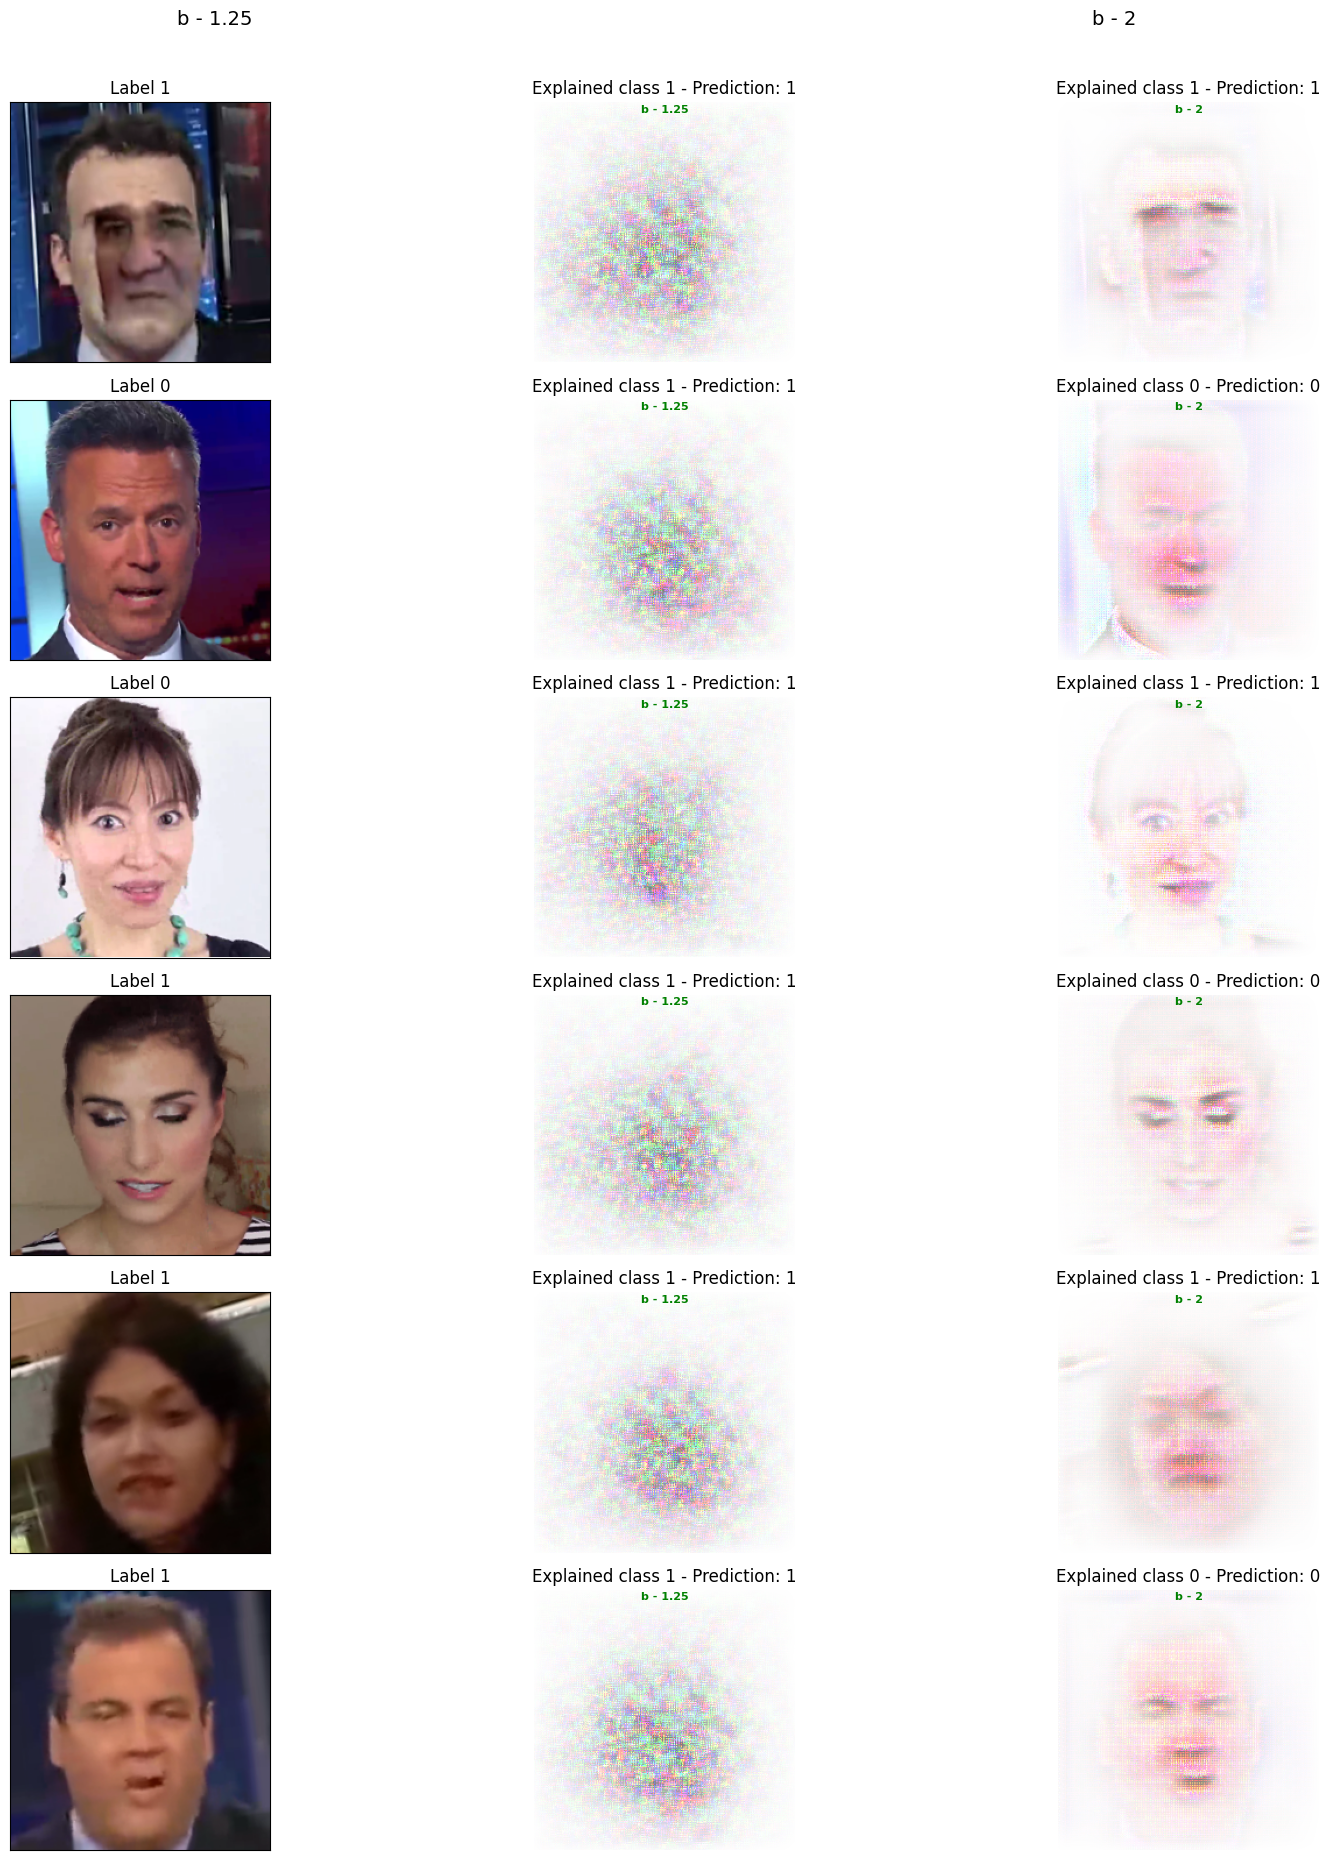

In [13]:
import matplotlib.pyplot as plt
from bcos.interpretability import grad_to_img, to_numpy
# Assuming you've already set up device, data loaders, and models
device = torch.device("cpu")

num_plots = 6
fig, axes = plt.subplots(num_plots, 3, figsize=(num_plots* 3, num_plots*3))  
for n in range(len(configs[:-1])):
    if 'b' in configs[n]['backbone_config'].keys():
        fig.text(0.25 + (n/len(configs[:-1])), 1.02, f"b - {configs[n]['backbone_config']['b']}", ha='center', va='bottom', fontsize=14)
test_data_loaders = prepare_testing_data(configs[0])
for model_idx, config in enumerate(configs[:-1]):
    # Prepare the model (detector)
    model_class = DETECTOR[config['model_name']]
    model = model_class(config)
    state_dict = torch.load(config['pretrained'])
    
    # Remove "module." prefix if present in the state_dict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = v
    model.load_state_dict(new_state_dict)
    model.to(device)

    # Loop through data loaders and process the first batch
    for key in test_data_loaders.keys():
        for i, data_dict in tqdm(enumerate(test_data_loaders[key]), total=len(test_data_loaders[key])):
            if i < num_plots:
                # Process data and ensure labels are binary (0 or 1)
                img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])
                if 'label_spe' in data_dict:
                    data_dict.pop('label_spe')
                data_dict['label'] = torch.where(data_dict['label'] != 0, 1, 0)

                for key in data_dict.keys():
                    if data_dict[key] is not None:
                        data_dict[key] = data_dict[key].to(device)

                # Take the first image and process it
                img = img_batch[0].unsqueeze(0).to(device)  # Process a single image
                label = label_batch[0]

                # Generate explanation (replace with your actual explanation function)
                model.backbone.eval()
                explanation = model.backbone.explain(img)
                
                # Convert the image to numpy format for visualization
                img_np = np.array(to_numpy(img[0, [0, 1, 2]].permute(1, 2, 0)) * 255, dtype=np.uint8)

                # Select subplot axes based on the model index (for arranging in 2x2 grid)
                row_idx = i #model_idx // 2  # Determine row (0 or 1)
                col_idx = model_idx+1 #* 2 
                if model_idx == 0:
                    # Plot the original image on the left subplot
                    axes[row_idx, model_idx].imshow(img_np, extent=(0, config['resolution'], 0, config['resolution']))
                    axes[row_idx, model_idx].set_title(f"Label {label}")
                    #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                    axes[row_idx, model_idx].set_xticks([])
                    axes[row_idx, model_idx].set_yticks([])

                # Plot the explanation (heatmap) on the right subplot
                axes[row_idx, col_idx].imshow(explanation['explanation'], cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))
                axes[row_idx, col_idx].set_title(f"Explained class {explanation['explained_class_idx']} - Prediction: {explanation['prediction']}")
                #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                axes[row_idx, col_idx].set_xticks([])
                axes[row_idx, col_idx].set_yticks([])
                axes[row_idx, col_idx].text(0.5, .99,  f"b - {config['backbone_config']['b']}", color='green', ha='center', va='top', fontsize=8, weight='bold', transform=axes[row_idx, col_idx].transAxes)

                for spine in axes[row_idx, col_idx].spines.values():
                    spine.set_visible(False)

            else:
                break  # Only process the first 3 batches (or less if break condition met)
        else:
            break  # Exit if the test data loader finishes
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

  0%|          | 6/2793 [00:01<11:44,  3.96it/s]


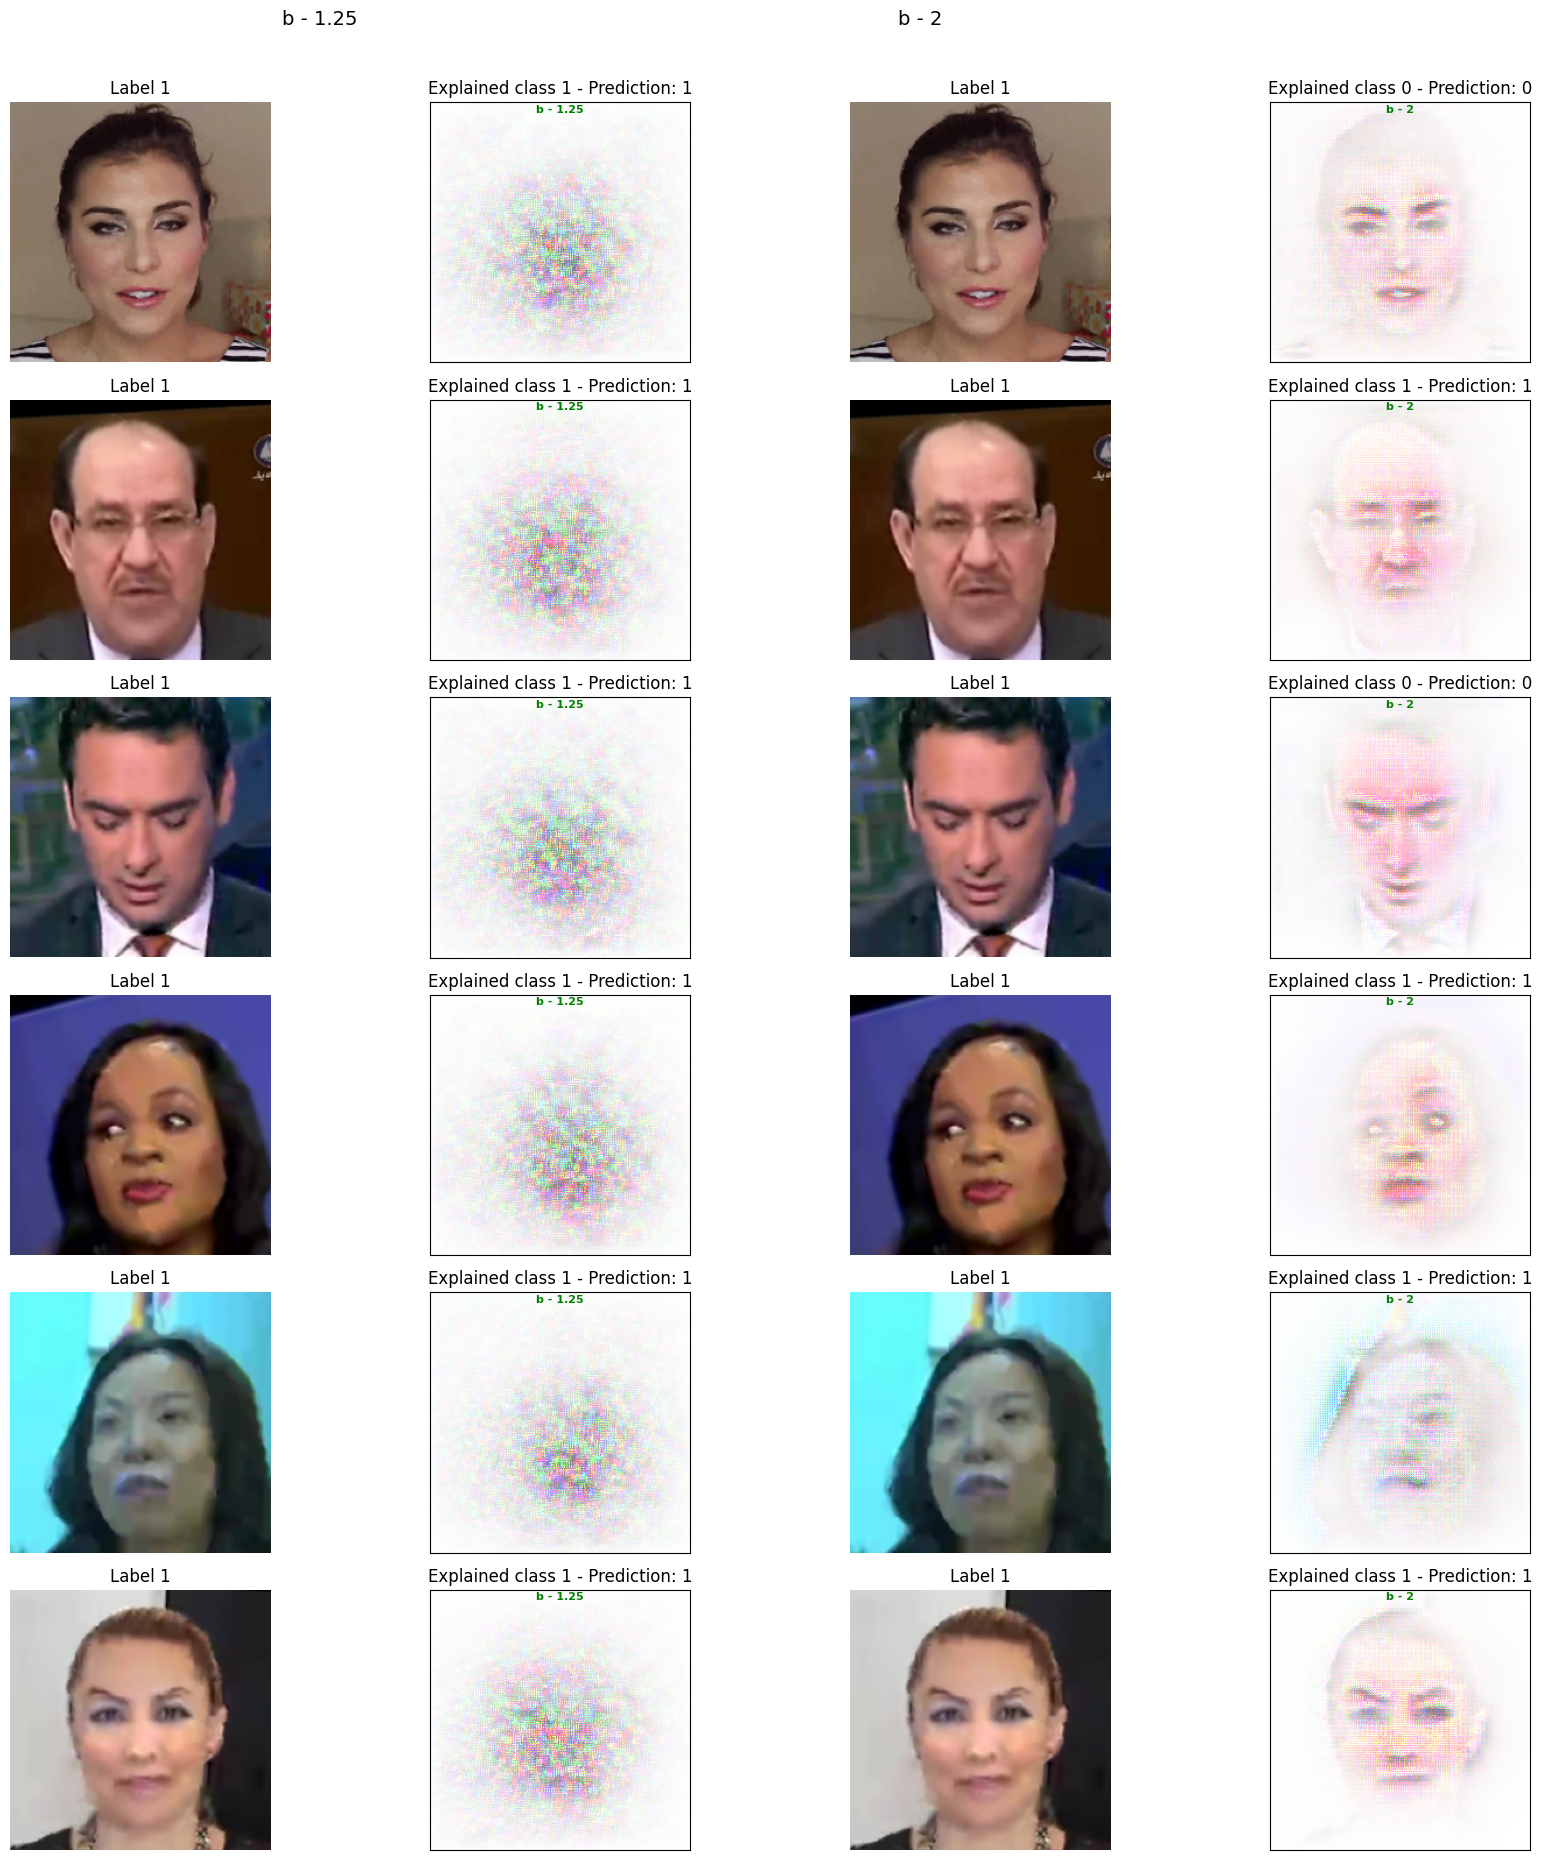

In [11]:
import matplotlib.pyplot as plt
from bcos.interpretability import grad_to_img, to_numpy
# Assuming you've already set up device, data loaders, and models
device = torch.device("cpu")

num_plots = 6
fig, axes = plt.subplots(num_plots, 4, figsize=(num_plots* 3, num_plots*3))  
for n in range(len(configs)):
    if 'b' in configs[n]['backbone_config'].keys():
        fig.text(0.25 + (n/len(configs)), 1.02, f"b - {configs[n]['backbone_config']['b']}", ha='center', va='bottom', fontsize=14)
test_data_loaders = prepare_testing_data(configs[0])
for model_idx, config in enumerate(configs[:-1]):
    # Prepare the model (detector)
    model_class = DETECTOR[config['model_name']]
    model = model_class(config)
    state_dict = torch.load(config['pretrained'])
    
    # Remove "module." prefix if present in the state_dict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = v
    model.load_state_dict(new_state_dict)
    model.to(device)

    # Loop through data loaders and process the first batch
    for key in test_data_loaders.keys():
        for i, data_dict in tqdm(enumerate(test_data_loaders[key]), total=len(test_data_loaders[key])):
            if i < num_plots:
                # Process data and ensure labels are binary (0 or 1)
                img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])
                if 'label_spe' in data_dict:
                    data_dict.pop('label_spe')
                data_dict['label'] = torch.where(data_dict['label'] != 0, 1, 0)

                for key in data_dict.keys():
                    if data_dict[key] is not None:
                        data_dict[key] = data_dict[key].to(device)

                # Take the first image and process it
                img = img_batch[0].unsqueeze(0).to(device)  # Process a single image
                label = label_batch[0]

                # Generate explanation (replace with your actual explanation function)
                model.backbone.eval()
                explanation = model.backbone.explain(img)
                
                # Convert the image to numpy format for visualization
                img_np = np.array(to_numpy(img[0, [0, 1, 2]].permute(1, 2, 0)) * 255, dtype=np.uint8)

                # Select subplot axes based on the model index (for arranging in 2x2 grid)
                row_idx = i #model_idx // 2  # Determine row (0 or 1)
                col_idx = model_idx * 2 

                # Plot the original image on the left subplot
                axes[row_idx, col_idx].imshow(img_np, extent=(0, config['resolution'], 0, config['resolution']))
                axes[row_idx, col_idx].set_title(f"Label {label}")
                #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                axes[row_idx, col_idx].set_xticks([])
                axes[row_idx, col_idx].set_yticks([])

                # Plot the explanation (heatmap) on the right subplot
                axes[row_idx, col_idx+1].imshow(explanation['explanation'], cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))
                axes[row_idx, col_idx+1].set_title(f"Explained class {explanation['explained_class_idx']} - Prediction: {explanation['prediction']}")
                #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                axes[row_idx, col_idx+1].set_xticks([])
                axes[row_idx, col_idx+1].set_yticks([])
                axes[row_idx, col_idx+1].text(0.5, .99,  f"b - {config['backbone_config']['b']}", color='green', ha='center', va='top', fontsize=8, weight='bold', transform=axes[row_idx, col_idx+1].transAxes)

                for spine in axes[row_idx, col_idx].spines.values():
                    spine.set_visible(False)

            else:
                break  # Only process the first 3 batches (or less if break condition met)
        else:
            break  # Exit if the test data loader finishes
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()